### 바벨스피치 - 텐서플로우 음성인식 예제

[light_weight_cnn](https://www.kaggle.com/alphasis/light-weight-cnn-lb-0-74)


### 1. 특징추출 
#### 1-1 slicence - chop_audio 개선  (송치성님)
#### 1-2 VAD 추가 (송치성님)
#### 1-3 MFC coff, MFCC 추가 (김영범님, 김소윤님)
#### 1-4 Kaldi 사용법 (번외, ?)

### 2. 분류기
#### 2-1 CNN 구조 변경 (박형순님)
#### 2-2 다른 분류기 stacking 고민 (엄상원님/이상열님, 128개를 -> 다른 분류기를 사용한다던가?)
#### 2-3 CV 개선 ?????????? (?)

### 3. 실험 환경
#### 3-1 aws-ec2 gpu 머신 실험 (이상열님/박형순님)
#### 3-2 aws-emr s3, spark 실험 (내일 화요일 교육)




### 머리말
- 이 노트북은 light-weight CNN을 만드는 것을 목표로합니다.
- 그것은 리샘플링 된 wav 파일 (속도 8000)의 specgram을 입력으로 사용합니다.
- LB 0.74를 얻으려면 epoch를 5로 설정하고 chop_audio (num = 1000)을 설정하고 모든 Conv 레이어 매개 변수를 두 배로 설정해야합니다.
- 이 스크립트는 Alex Ozerin의 기준선에 약간의 영향을 미치지 만 원본 WAV 파일 (16000 샘플 속도)을 사용하면 더 높은 점수를 얻을 수 있다고 생각합니다.


### File Structure
- This script assumes data are stored in following strcuture:

speech

├── test

│ └── audio #test wavfiles

├── train

│ ├── audio #train wavfiles

└── model #store models

│

└── out #store sub.csv

### 이 스크립트 개선
- 이것은 light-weight CNN이기 때문에 성능이 제한적입니다. 실력을 향상시키는 몇 가지 방법이 있습니다.
- 샘플링 된 원본 wav 파일을 대신 사용하십시오.
- chop_audio를 사용하여 더 많은 '무음' wav 파일을 만듭니다.
- 더 깊은 CNN을 구축하거나 RNN을 사용하십시오.
    - Train for longer epochs
    - After Words
    - It's still a long way to reach LB 0.88.
- 사실, 나는 CNN이 그 높은 곳에 도달 할 수 있을지 의심 스럽다.
- CNN을 사용하여 wav 파일에 라벨을 붙이는 것에 대한 의견 섹션에서 아이디어를 공유하십시오. 

In [1]:
import os
import numpy as np
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from glob import glob
import re
import pandas as pd
import gc
from scipy.io import wavfile

from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
import keras

Using TensorFlow backend.


In [42]:
import sys
sys.version

'3.5.2 (default, Nov 23 2017, 16:37:01) \n[GCC 5.4.0 20160609]'

- The original sample rate is 16000, and we will resample it to 8000 to reduce data size.

In [2]:
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

#src folders
root_path = r'.'
out_path = r'.'
model_path = r'.'
train_data_path = os.path.join(root_path, 'input', 'train', 'audio')
test_data_path = os.path.join(root_path, 'input', 'test', 'audio')

In [3]:
test_data_path

'./input/test/audio'

In [4]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [5]:
def list_wavs_fname(dirpath, ext='wav'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

- pad_audio는 모두 16000(1 초) 미만의 오디오를 0으로 채워서 모두 길이가 동일하게 만듭니다.

- chop_audio는 16000보다 큰 오디오 (예 : 배경 노이즈 폴더의 wav 파일)를 16000 길이로 잘라냅니다. 또한 매개 변수 'num'이 주어지면 하나의 큰 wav 파일에서 여러 개의 청크가 만들어집니다.

- label_transform 라벨을 dummies 값으로 변환합니다. softmax와 함께 사용되어 라벨을 예측합니다.

In [6]:
def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

- 다음으로 위에서 선언 한 함수를 사용하여 x_train과 y_train을 생성합니다.
- label_index는 더미 값을 만들기 위해 팬더가 사용하는 인덱스입니다. 나중에 사용할 수 있도록 저장해야 합니다.

In [112]:
labels, fnames = list_wavs_fname(train_data_path)

new_sample_rate = 8000
y_train = []
x_train = []

./input/train/audio


In [8]:
len(labels)

64727

In [9]:
len(fnames)

64727

In [113]:
for label, fname in zip(labels, fnames):
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
    else: n_samples = [samples]
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        y_train.append(label)
        x_train.append(specgram)

/usr/local/lib/python3.5/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [114]:
type(y_train)

list

In [11]:
len(x_train)

64841

In [151]:
x_train = np.array(x_train)
x_train = x_train.reshape(tuple(list(x_train.shape) + [1]))

In [13]:
x_train.shape

(64841, 99, 81, 1)

In [14]:
x_train.ndim

4

In [98]:
y_train = label_transform(y_train)
label_index = y_train.columns.values

In [16]:
label_index

array(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop',
       'unknown', 'up', 'yes'], dtype=object)

In [99]:
y_train = y_train.values
y_train = np.array(y_train)
#del labels, fnames
#gc.collect()

In [18]:
y_train

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [19]:
y_train.shape

(64841, 12)

In [20]:
input_shape = (99, 81, 1)
nclass = 12

In [21]:
inp = Input(shape=input_shape)
norm_inp = BatchNormalization()(inp)

In [22]:
inp

<tf.Tensor 'input_1:0' shape=(?, 99, 81, 1) dtype=float32>

In [23]:
norm_inp

<tf.Tensor 'batch_normalization_1/cond/Merge:0' shape=(?, 99, 81, 1) dtype=float32>

In [24]:
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(norm_inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Flatten()(img_1)

In [25]:
img_1

<tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>

In [26]:
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

In [27]:
dense_1

<tf.Tensor 'dense_3/Softmax:0' shape=(?, 12) dtype=float32>

In [28]:
model = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

In [29]:
model

In [30]:
opt

In [31]:
model.compile(optimizer=opt, loss=losses.binary_crossentropy)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 99, 81, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 81, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 80, 8)         40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 79, 8)         264       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 39, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 39, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 37, 16)        1168      
__________

In [43]:
xtrain, xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size=0.1, random_state=2017)

In [44]:
xtrain.shape

(58356, 99, 81, 1)

In [45]:
xvalid.shape

(6485, 99, 81, 1)

In [46]:
ytrain.shape

(58356, 12)

In [47]:
yvalid.shape

(6485, 12)

In [48]:
from keras.utils import multi_gpu_model

In [49]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9060370253613549053
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 7500428084
locality {
  bus_id: 1
}
incarnation: 12245172255697124796
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1d.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 7500428084
locality {
  bus_id: 1
}
incarnation: 9692446858044313324
physical_device_desc: "device: 1, name: Tesla M60, pci bus id: 0000:00:1e.0"
]


In [143]:
parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss=losses.binary_crossentropy,
                       optimizer=opt)
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 99, 81, 1)    0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 99, 81, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 99, 81, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 12)           314368      lambda_5[0][0]                   
                                                                 lambda_6[0][0]                   
__________

In [36]:
history = parallel_model.fit(xtrain, ytrain, batch_size=16, validation_data=(xvalid, yvalid), epochs=300, shuffle=True, verbose=2)

Train on 58356 samples, validate on 6485 samples
Epoch 1/300
 - 54s - loss: 0.0645 - val_loss: 0.0501
Epoch 2/300
 - 54s - loss: 0.0603 - val_loss: 0.0391
Epoch 3/300
 - 54s - loss: 0.0557 - val_loss: 0.0457
Epoch 4/300
 - 54s - loss: 0.0551 - val_loss: 0.0421
Epoch 5/300
 - 54s - loss: 0.0512 - val_loss: 0.0393
Epoch 6/300
 - 54s - loss: 0.0495 - val_loss: 0.0364
Epoch 7/300
 - 54s - loss: 0.0489 - val_loss: 0.0397
Epoch 8/300
 - 54s - loss: 0.0461 - val_loss: 0.0348
Epoch 9/300
 - 54s - loss: 0.0452 - val_loss: 0.0321
Epoch 10/300
 - 54s - loss: 0.0449 - val_loss: 0.0343
Epoch 11/300
 - 54s - loss: 0.0439 - val_loss: 0.0332
Epoch 12/300
 - 54s - loss: 0.0427 - val_loss: 0.0345
Epoch 13/300
 - 54s - loss: 0.0413 - val_loss: 0.0308
Epoch 14/300
 - 54s - loss: 0.0414 - val_loss: 0.0296
Epoch 15/300
 - 54s - loss: 0.0407 - val_loss: 0.0272
Epoch 16/300
 - 54s - loss: 0.0398 - val_loss: 0.0285
Epoch 17/300
 - 54s - loss: 0.0401 - val_loss: 0.0295
Epoch 18/300
 - 54s - loss: 0.0392 - val_l

 - 54s - loss: 0.0194 - val_loss: 0.0230
Epoch 152/300
 - 54s - loss: 0.0193 - val_loss: 0.0207
Epoch 153/300
 - 54s - loss: 0.0194 - val_loss: 0.0212
Epoch 154/300
 - 54s - loss: 0.0203 - val_loss: 0.0242
Epoch 155/300
 - 54s - loss: 0.0192 - val_loss: 0.0224
Epoch 156/300
 - 54s - loss: 0.0189 - val_loss: 0.0218
Epoch 157/300
 - 54s - loss: 0.0201 - val_loss: 0.0225
Epoch 158/300
 - 54s - loss: 0.0194 - val_loss: 0.0246
Epoch 159/300
 - 54s - loss: 0.0188 - val_loss: 0.0221
Epoch 160/300
 - 54s - loss: 0.0206 - val_loss: 0.0203
Epoch 161/300
 - 54s - loss: 0.0192 - val_loss: 0.0207
Epoch 162/300
 - 54s - loss: 0.0189 - val_loss: 0.0252
Epoch 163/300
 - 54s - loss: 0.0206 - val_loss: 0.0225
Epoch 164/300
 - 54s - loss: 0.0190 - val_loss: 0.0214
Epoch 165/300
 - 54s - loss: 0.0193 - val_loss: 0.0223
Epoch 166/300
 - 54s - loss: 0.0186 - val_loss: 0.0228
Epoch 167/300
 - 54s - loss: 0.0191 - val_loss: 0.0249
Epoch 168/300
 - 54s - loss: 0.0191 - val_loss: 0.0253
Epoch 169/300
 - 54s - l

 - 54s - loss: 0.0165 - val_loss: 0.0221


In [22]:
#model.fit(x_train, y_train, batch_size=16, validation_data=(x_valid, y_valid), epochs=500, shuffle=True, verbose=2)

In [26]:
#parallel_model.save(os.path.join(model_path, 'parallel_cnn_epochs_test_20171217.model'))

In [37]:
model.save(os.path.join(model_path, 'cnn_epochs_300_20171217.model'))

In [140]:
from keras.models import load_model
#model = load_model('cnn_epochs3_20171211.model')
model = load_model('cnn_epochs_300_20171217.model')

In [52]:
import matplotlib.pyplot as plt

In [53]:
%matplotlib inline

In [33]:
history.history

{'loss': [0.08110813286689908, 0.070448522786859119],
 'val_loss': [0.062765511956551306, 0.048562809072417668]}

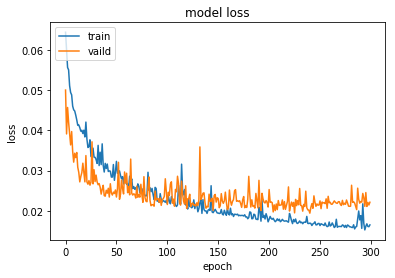

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left')
plt.show()

In [54]:
def test_data_generator(batch=16):
    fpaths = glob(os.path.join(test_data_path, '*wav'))
    i = 0
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        rate, samples = wavfile.read(path)
        samples = pad_audio(samples)
        resampled = signal.resample(samples, int(new_sample_rate / rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        imgs.append(specgram)
        fnames.append(path.split('\\')[-1])
        if i == batch:
            i = 0
            imgs = np.array(imgs)
            imgs = imgs.reshape(tuple(list(imgs.shape) + [1]))
            yield fnames, imgs
    if i < batch:
        imgs = np.array(imgs)
        imgs = imgs.reshape(tuple(list(imgs.shape) + [1]))
        yield fnames, imgs
    raise StopIteration()

In [40]:
index = []
results = []
for fnames, imgs in test_data_generator(batch=32):
    predicts = model.predict(imgs)
    predicts = np.argmax(predicts, axis=1)
    predicts = [label_index[p] for p in predicts]
    index.extend(fnames)
    results.extend(predicts)

index = [w.replace('./input/test/audio/', '') for w in index]
df = pd.DataFrame(columns=['fname', 'label'])
df['fname'] = index
df['label'] = results

df.to_csv(os.path.join(out_path, 'sub_300.csv'), index=False)

In [141]:
model.layers[15]

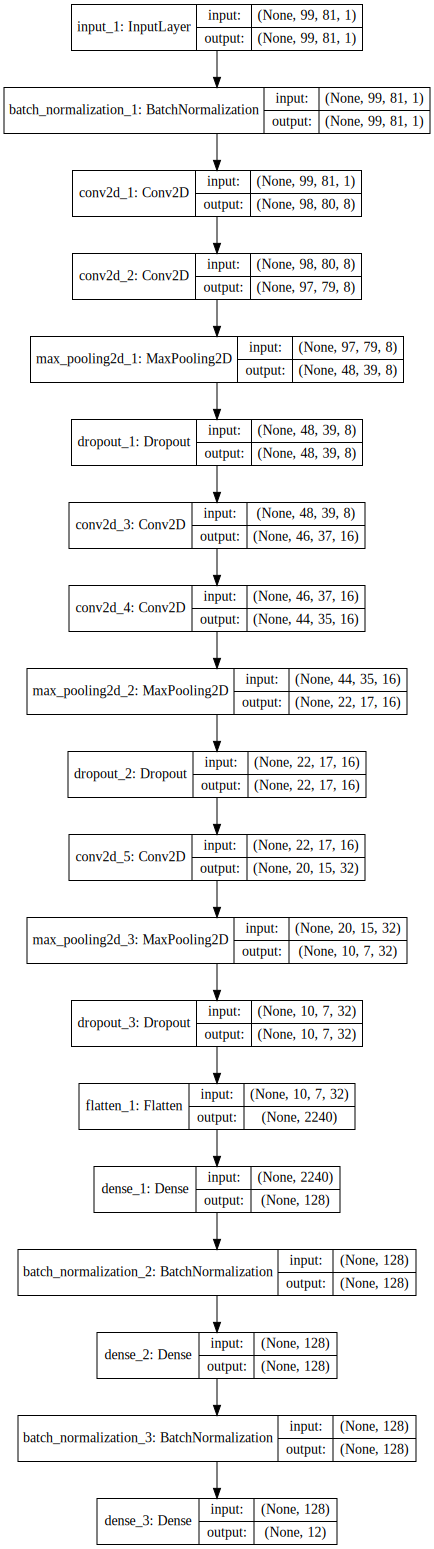

In [57]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [60]:
from keras.models import Model

In [148]:
parallel_model.input

<tf.Tensor 'input_1_2:0' shape=(?, 99, 81, 1) dtype=float32>

In [149]:
intermediate_layer_model_flatten = Model(input=parallel_model.input,output=model.layers[15].output)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ba...)`
  """Entry point for launching an IPython kernel.


In [150]:
intermediate_layer_model_flatten

In [152]:
flatten_value = intermediate_layer_model_flatten.predict(x_train)

In [153]:
flatten_value

array([[-1.55775964, -2.29262328,  3.67452312, ..., -1.92921543,
         1.28039193, -0.95891011],
       [-1.55775964, -1.09495223,  1.21194386, ..., -1.5982722 ,
        -1.72894645, -0.95891011],
       [-1.55775964, -2.29262328,  2.46265531, ..., -1.92921543,
         1.05937147, -0.95891011],
       ..., 
       [-0.75167358, -2.29262328, -1.7639854 , ..., -1.92921543,
        -1.72894645, -0.95891011],
       [-1.55775964, -0.85432017, -1.62072778, ..., -1.92921543,
        -1.72894645, -0.95891011],
       [-0.89543515, -0.42076492, -1.7639854 , ..., -0.73357844,
        -1.72894645, -0.95891011]], dtype=float32)

In [154]:
type(flatten_value)

numpy.ndarray

In [155]:
flatten_value.shape

(64841, 128)

In [156]:
np.average(flatten_value, axis=1)

array([-0.007158  , -0.20030661, -0.26745838, ..., -0.20278145,
       -0.15263389, -0.31903598], dtype=float32)

In [76]:
test_data_path = os.path.join(root_path, 'input', 'test', 'audio')

In [157]:
results = []
#results = np.array([], dtype=np.float64)
for fnames, imgs in test_data_generator(batch=32):
    predicts = intermediate_layer_model_flatten.predict(imgs)
    #predicts = model.predict(imgs)
    #predicts = np.argmax(predicts, axis=1)
    #predicts = [label_index[p] for p in predicts]
    results.extend(predicts)
    #results = np.append(results, predicts)

In [158]:
results2 = np.array(results)

In [75]:
results2.shape

(158538, 128)

In [76]:
type(results2)

numpy.ndarray

In [159]:
np.average(results2, axis=1)

array([-0.30404228, -0.07321991, -0.10252588, ..., -0.00283034,
       -0.3715995 , -0.2905556 ], dtype=float32)

In [160]:
print(results2, 2)

[[-1.42333233 -2.29262328 -0.65810549 ..., -1.92921543  0.29229116
   0.28648484]
 [ 2.48813868 -0.49979937 -1.7639854  ..., -1.92921543 -1.72894645
  -0.95891011]
 [ 1.43944418 -2.29262328  1.93460131 ..., -1.92921543  2.19681835
   1.75118649]
 ..., 
 [-1.24054372  0.99017644  0.45560026 ...,  2.06818366 -1.72894645
   1.64244711]
 [-1.42722297 -2.29262328 -1.7639854  ..., -1.92921543 -1.72894645
   1.44473851]
 [-0.9950726   0.00889754  0.38673115 ..., -1.42307913 -1.3963145
   0.37145877]] 2


In [161]:
#https://flonelin.wordpress.com/2016/07/26/tuning-xgboostextream-gradient-boosting/
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softmax'
    param['eta'] = 0.02
    param['max_depth'] = 8
    param['silent'] = 1
    param['num_class'] = 12
    param['eval_metric'] = "merror"
    param['min_child_weight'] = 3
    param['subsample'] = 0.7
    param['scale_pos_weight'] = 1
    #param['gamma'] = 0.2
    param['reg_alpha'] = 0.005  
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val # 초기값 설정 랜덤 안되게
    num_rounds = num_rounds
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y) # D매트릭스로 바꿔줘야 한다.
    feature_names = xgtrain.feature_names

    # test의 타겟값을 넣은 xgb model
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    # test의 타겟값을 넣지 않은 xgb model
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model, feature_names

In [79]:
import xgboost as xgb
import random
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import Imputer

In [115]:
y_train2 = label_transform(y_train)
#y_train = y_train.values

In [117]:
y_train2.shape

(64841, 12)

In [118]:
type(y_train2)

pandas.core.frame.DataFrame

In [119]:
y_train2 = y_train2.apply(lambda x: x.argmax(), axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


In [120]:
y_train2.shape

(64841,)

In [121]:
y_train2.head()

0    left
1    left
2    left
3    left
4    left
dtype: object

In [122]:
target_num_map = {'down':0, 'go':1, 'left':2, 'no':3, 'off':4, 'on':5, 'right':6, 'silence':7, 'stop':8, 'unknown':9, 'up':10, 'yes':11}
y_train3 = np.array(y_train2.apply(lambda x: target_num_map[x]))
y_train3

array([2, 2, 2, ..., 4, 4, 4])

In [123]:
flatten_value.shape

(64841, 128)

In [125]:
y_train3.shape

(64841,)

In [126]:
y_train3.max()

11

In [162]:
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(flatten_value.shape[0])):
        dev_X, val_X = flatten_value[dev_index,:], flatten_value[val_index,:]
        dev_y, val_y = y_train3[dev_index], y_train3[val_index]
        preds, model, feature_names = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(accuracy_score(val_y, preds))
        print(cv_scores)
        break

[0]	train-merror:0.095022	test-merror:0.122831
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 20 rounds.
[1]	train-merror:0.075648	test-merror:0.097309
[2]	train-merror:0.06838	test-merror:0.089213
[3]	train-merror:0.061613	test-merror:0.081348
[4]	train-merror:0.058953	test-merror:0.079266
[5]	train-merror:0.056659	test-merror:0.076644
[6]	train-merror:0.054557	test-merror:0.0741
[7]	train-merror:0.053497	test-merror:0.072943
[8]	train-merror:0.052842	test-merror:0.071478
[9]	train-merror:0.051608	test-merror:0.070784
[10]	train-merror:0.050258	test-merror:0.07009
[11]	train-merror:0.049584	test-merror:0.06955
[12]	train-merror:0.048774	test-merror:0.068548
[13]	train-merror:0.048292	test-merror:0.069088
[14]	train-merror:0.047849	test-merror:0.068394
[15]	train-merror:0.04702	test-merror:0.067546
[16]	train-merror:0.046827	test-merror:0.066852
[17]	train-merror:0.046557	test-merror:0.067006
[18]	

[167]	train-merror:0.015635	test-merror:0.039556
[168]	train-merror:0.015345	test-merror:0.039093
[169]	train-merror:0.015326	test-merror:0.039016
[170]	train-merror:0.015249	test-merror:0.038939
[171]	train-merror:0.015095	test-merror:0.038862
[172]	train-merror:0.014941	test-merror:0.038785
[173]	train-merror:0.014806	test-merror:0.038553
[174]	train-merror:0.014748	test-merror:0.038091
[175]	train-merror:0.014613	test-merror:0.038091
[176]	train-merror:0.014439	test-merror:0.038014
[177]	train-merror:0.014343	test-merror:0.037937
[178]	train-merror:0.014247	test-merror:0.037782
[179]	train-merror:0.014035	test-merror:0.037782
[180]	train-merror:0.013957	test-merror:0.037628
[181]	train-merror:0.013765	test-merror:0.037474
[182]	train-merror:0.01363	test-merror:0.03732
[183]	train-merror:0.013495	test-merror:0.037243
[184]	train-merror:0.013418	test-merror:0.037243
[185]	train-merror:0.013302	test-merror:0.037166
[186]	train-merror:0.013206	test-merror:0.037011
[187]	train-merror:0.0

[335]	train-merror:0.003297	test-merror:0.026293
[336]	train-merror:0.003258	test-merror:0.026216
[337]	train-merror:0.003219	test-merror:0.026293
[338]	train-merror:0.003142	test-merror:0.026293
[339]	train-merror:0.003123	test-merror:0.026139
[340]	train-merror:0.003123	test-merror:0.026062
[341]	train-merror:0.003046	test-merror:0.025908
[342]	train-merror:0.002988	test-merror:0.025985
[343]	train-merror:0.002969	test-merror:0.025831
[344]	train-merror:0.002969	test-merror:0.025908
[345]	train-merror:0.00293	test-merror:0.025908
[346]	train-merror:0.002872	test-merror:0.025754
[347]	train-merror:0.002872	test-merror:0.025677
[348]	train-merror:0.002815	test-merror:0.025754
[349]	train-merror:0.002853	test-merror:0.025831
[350]	train-merror:0.002738	test-merror:0.025754
[351]	train-merror:0.002738	test-merror:0.025754
[352]	train-merror:0.002718	test-merror:0.025754
[353]	train-merror:0.002718	test-merror:0.025831
[354]	train-merror:0.002699	test-merror:0.025677
[355]	train-merror:0.

[503]	train-merror:0.000386	test-merror:0.020819
[504]	train-merror:0.000386	test-merror:0.020896
[505]	train-merror:0.000386	test-merror:0.020742
[506]	train-merror:0.000386	test-merror:0.020742
[507]	train-merror:0.000386	test-merror:0.020665
[508]	train-merror:0.000386	test-merror:0.020665
[509]	train-merror:0.000386	test-merror:0.02051
[510]	train-merror:0.000366	test-merror:0.02051
[511]	train-merror:0.000347	test-merror:0.02051
[512]	train-merror:0.000366	test-merror:0.020433
[513]	train-merror:0.000366	test-merror:0.020433
[514]	train-merror:0.000366	test-merror:0.020433
[515]	train-merror:0.000347	test-merror:0.020433
[516]	train-merror:0.000328	test-merror:0.020433
[517]	train-merror:0.000328	test-merror:0.020356
[518]	train-merror:0.000328	test-merror:0.020356
[519]	train-merror:0.000308	test-merror:0.020356
[520]	train-merror:0.000308	test-merror:0.020433
[521]	train-merror:0.000308	test-merror:0.020279
[522]	train-merror:0.000308	test-merror:0.020356
[523]	train-merror:0.00

In [128]:
preds

array([ 2.,  2.,  2., ...,  4.,  4.,  4.], dtype=float32)

In [129]:
model

In [163]:
n_rounds = model.best_ntree_limit
print(n_rounds)
#print('Geting predictions...')
#y_pred, model = runXGB(latten_value, train_y3, results2, num_rounds=n_rounds)

543


In [108]:
#out_df_label = out_df.apply(np.argmax, axis=1)
#out_df2 = out_df.applymap(int)
#out_df2.columns = ['label']
#out_df_label2 = [label_index[p] for p in out_df2['label']]

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [180]:
#target_num_map = {'down':0, 'go':1, 'left':2, 'no':3, 'off':4, 'on':5, 'right':6, 'silence':7, 'stop':8, 'unknown':9, 'up':10, 'yes':11}

In [182]:
#out_df_label2

In [212]:
model

In [164]:
index = []
results = []
for fnames, imgs in test_data_generator(batch=32):
    predicts = intermediate_layer_model_flatten.predict(imgs)
    test = np.array(predicts)
    #print(test.shape)
    xgtest = xgb.DMatrix(test)
    predicts = model.predict(xgtest)
    #predicts = np.argmax(predicts, axis=1)
    #predicts = [label_index[p] for p in predicts]
    index.extend(fnames)
    results.extend(predicts)

In [165]:
results[1:10]

[5.0, 3.0, 6.0, 9.0, 9.0, 9.0, 7.0, 4.0, 9.0]

In [166]:
results3 = list(map(int, results))
results4 = [label_index[p] for p in results3]

In [167]:
results4[1:10]

['on',
 'no',
 'right',
 'unknown',
 'unknown',
 'unknown',
 'silence',
 'off',
 'unknown']

In [168]:
index = [w.replace('./input/test/audio/', '') for w in index]
index

['clip_bd6d0fb25.wav',
 'clip_3e7a56353.wav',
 'clip_c5884a6cb.wav',
 'clip_ebf0d1f7b.wav',
 'clip_2f714f052.wav',
 'clip_05bfe5e6a.wav',
 'clip_317b4a205.wav',
 'clip_292983fee.wav',
 'clip_e086bfc8e.wav',
 'clip_d0d7fa566.wav',
 'clip_b6ad181d9.wav',
 'clip_738893dd9.wav',
 'clip_c9eb8d1a9.wav',
 'clip_d79dd9bf8.wav',
 'clip_e40213c24.wav',
 'clip_a72ff422a.wav',
 'clip_cc61982d4.wav',
 'clip_8e1fa0dee.wav',
 'clip_0713f99f1.wav',
 'clip_9592bad93.wav',
 'clip_f3fe04537.wav',
 'clip_0e044ee58.wav',
 'clip_654389dc0.wav',
 'clip_88505d8a5.wav',
 'clip_40ea16c6b.wav',
 'clip_eb4ba59f8.wav',
 'clip_d32e78089.wav',
 'clip_1aa0e6858.wav',
 'clip_4b0477055.wav',
 'clip_bb88fb22b.wav',
 'clip_11935b0ae.wav',
 'clip_7be97e288.wav',
 'clip_0ac9b2db3.wav',
 'clip_9d22b7f6b.wav',
 'clip_af90c2c40.wav',
 'clip_4a8605cc5.wav',
 'clip_6bd6992a9.wav',
 'clip_fa2427823.wav',
 'clip_b79cc8d26.wav',
 'clip_8054ecf5e.wav',
 'clip_b32974acd.wav',
 'clip_60d40986d.wav',
 'clip_0195ecefa.wav',
 'clip_5cf3

In [169]:
df = pd.DataFrame(columns=['fname', 'label'])
df['fname'] = index
df['label'] = results4
df.to_csv(os.path.join(out_path, 'xgboost_1000_2.csv'), index=False)